## Autonomous and non-autonomous systems
The first part of this notebook studies the differences in the evolution between the autonomous and non-autonomous systems. Specifically, the evolution is first simulated according to the standard model for a time given by t_max. Then, the evolution continues from t_max up to t_max_2 weeks, but in this second period the system is evolved in parallel, following both the original equations and those with the damage term removed. The two trajectories are then plotted for comparison. Meanwhile, a study is conducted to assess the relevance of the damage term compared to the other terms in the evolution equations for N and D. Plots showing their evolution over time are displayed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import configparser
import pandas as pd
import os

### One-step update in the system's evolution
Both the autonomous and non-autonomous systems are implemented.

In [35]:
#Non autonomous
def one_step(t, dt, dx, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, H_i, C_i, M_i, par, diffusion, boundary, terms_N, terms_D):

    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = par
    D_H, D_C, D_M = diffusion

    for i in range(len(H)):

        ev_H(i, dt, dx, D_H, d_H, k1, H_i, H, M, D, H_new, boundary)
        ev_C(i, dt, dx, D_C, d_C, k2, C_i, C, H, D, C_new, boundary)
        ev_M(i, dt, dx, D_M, d_M, k3, M_i, M, D, M_new, boundary)
        ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new, terms_N)
        ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new, terms_D)
        ev_R(i, dt, d_D, k4, k6, M, D, R, R_new)

#Autonomous
def one_step_autonomous(dt, dx, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, H_i, C_i, M_i, par, diffusion, boundary):

    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = par
    D_H, D_C, D_M = diffusion

    for i in range(len(H)):

        ev_H(i, dt, dx, D_H, d_H, k1, H_i, H, M, D, H_new, boundary)
        ev_C(i, dt, dx, D_C, d_C, k2, C_i, C, H, D, C_new, boundary)
        ev_M(i, dt, dx, D_M, d_M, k3, M_i, M, D, M_new, boundary)
        ev_N_autonomous(i, dt, k4, k5, R, C, N, N_new)
        ev_D_autonomous(i, dt, d_D, k5, k6, C, M, N, D, D_new)
        ev_R(i, dt, d_D, k4, k6, M, D, R, R_new)

### Damage function

In [3]:
def damage(t, sigma, m, h):

    if t==0 or t <=1e-14:
        return 0.
    else:
       return h / (t * sigma * np.sqrt(2*np.pi)) * np.exp(-(np.log(t) - m)**2 / (2. * sigma**2))

### Diffusion functions

In [92]:
def diff_H(i, dx, D_H, H, precision=14):
    if i == 0:
        diff = H[i+1] - H[i]
    elif i == len(H) - 1:
        diff = H[i-1] - H[i]
    else:
        diff = H[i+1] + H[i-1] - 2 * H[i]
    
#Round the relative difference to avoid small floating-point errors
    if round(diff / (abs(H[i]) + 1e-14), precision) == 0:
        return 0
    else:
        return D_H / dx**2 * diff

def diff_C(i, dx, D_C, C, precision=14):
    if i == 0:
        diff = C[i+1] - C[i]
    elif i == len(C) - 1:
        diff = C[i-1] - C[i]
    else:
        diff = C[i+1] + C[i-1] - 2 * C[i]
    
    if round(diff / (abs(C[i]) + 1e-14), precision) == 0:
        return 0
    else:
        return D_C / dx**2 * diff

def diff_M(i, dx, D_M, M, precision=14):
    if i == 0:
        diff = M[i+1] - M[i]
    elif i == len(M) - 1:
        diff = M[i-1] - M[i]
    else:
        diff = M[i+1] + M[i-1] - 2 * M[i]
    
    if round(diff / (abs(M[i]) + 1e-14), precision) == 0:
        return 0
    else:
        return D_M / dx**2 * diff

### Evolution of the immune cells
Possible boundary conditions:
- periodic
- evolving_sym: the rightmost and leftmost cells are initialized in the same way and evolve like the inner ones
- evolving_asym: the rightmost and leftmost cells are initialized differently and evolve like the inner ones
- fixed_sym: he rightmost and leftmost cells are initialized in the same way and cannot evolve
- fixed_asym: the rightmost and leftmost cells are initialised differently and cannot evolve

In [36]:
def ev_H(i, dt, dx, D_H, d_H, k1, H_i, H, M, D, H_new, boundary):
    
    if boundary in ['evolving_sym', 'evolving_asym']:
        H_new[i] = H[i] + dt * (diff_H(i, dx, D_H, H) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
    elif boundary in ['fixed_sym', 'fixed_asym']:
        if i==0 or i==len(H)-1:
            H_new[i] = H[i]
        else:
            H_new[i] = H[i] + dt * (diff_H(i, dx, D_H, H) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
    elif boundary=='periodic':
        if i==0:
            H_new[i] = H[i] + dt * (D_H / dx**2 * (H[i+1] + H[len(H)-1] - 2*H[i]) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
        elif i==len(H)-1:
            H_new[i] = H[i] + dt * (D_H / dx**2 * (H[0] + H[i-1] - 2*H[i]) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
        else:
            H_new[i] = H[i] + dt * (D_H / dx**2 * (H[i+1] + H[i-1] - 2*H[i]) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
    else:
        print('Simulation cannot proceed due to invalid boundary conditions.')

def ev_C(i, dt, dx, D_C, d_C, k2, C_i, C, H, D, C_new, boundary):
    
    if boundary in ['evolving_sym', 'evolving_asym']:
        C_new[i] = C[i] + dt * (diff_C(i, dx, D_C, C) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
    elif boundary in ['fixed_sym', 'fixed_asym']:
        if i==0 or i==len(C)-1:
            C_new[i] = C[i]
        else:
            C_new[i] = C[i] + dt * (diff_C(i, dx, D_C, C) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
    elif boundary=='periodic':
        if i==0:
            C_new[i] = C[i] + dt * (D_C / dx**2 * (C[i+1] + C[len(C)-1] - 2*C[i]) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
        elif i==N_cells-1:
            C_new[i] = C[i] + dt * (D_C / dx**2 * (C[0] + C[i-1] - 2*C[i]) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
        else:
            C_new[i] = C[i] + dt * (D_C / dx**2 * (C[i+1] + C[i-1] - 2*C[i]) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
    else:
        print('Simulation cannot proceed due to invalid boundary conditions.')
   
def ev_M(i, dt, dx, D_M, d_M, k3, M_i, M, D, M_new, boundary):
    
    if boundary in ['evolving_sym', 'evolving_asym']:
        M_new[i] = M[i] + dt * (diff_M(i, dx, D_M, M) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
    elif boundary in ['fixed_sym', 'fixed_asym']:
        if i==0 or i==len(M)-1:
            M_new[i] = M[i]
        else:
            M_new[i] = M[i] + dt * (diff_M(i, dx, D_M, M) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
    elif boundary=='periodic':
        if i==0:
            M_new[i] = M[i] + dt * (D_M / dx**2 * (M[i+1] + M[len(M)-1] - 2*M[i]) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
        elif i==len(M)-1:
            M_new[i] = M[i] + dt * (D_M / dx**2 * (M[0] + M[i-1] - 2*M[i]) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
        else:
            M_new[i] = M[i] + dt * (D_M / dx**2 * (M[i+1] + M[i-1] - 2*M[i]) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
    else:
        print('Simulation cannot proceed due to invalid boundary conditions.')
            

### Evolution of the composition of muscle tissue

To quantify how relevant the damage term is in the evolution, its value in the second cell of the row is stored at each time step, along with the values of the other terms present in the equations where it appears. This will allow us to observe when the damage becomes negligible.

In [37]:
def ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new, terms_N):
    N_new[i] = N[i] + dt * (k4 * R[i] - N[i] * (k5 * C[i] + damage(t, sigma, m, h)))
    if i==1:
        terms_N[0].append(N[i])
        terms_N[1].append(dt * k4 * R[i])
        terms_N[2].append(dt * N[i] * k5 * C[i])
        terms_N[3].append(dt * N[i] * damage(t, sigma, m, h))
def ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new, terms_D):
    D_new[i] = D[i] + dt * (N[i] * (k5 * C[i] + damage(t, sigma, m, h)) - D[i] * (k6 * M[i] + d_D))
    if i==1:
        terms_D[0].append(D[i])
        terms_D[1].append(dt * D[i] * k6 * M[i])
        terms_D[2]. append(dt *  D[i] * d_D)

def ev_N_autonomous(i, dt, k4, k5, R, C, N, N_new):
    N_new[i] = N[i] + dt * (k4 * R[i] - N[i] * k5 * C[i])
        
def ev_D_autonomous(i, dt, d_D, k5, k6, C, M, N, D, D_new):
    D_new[i] = D[i] + dt * (N[i] * k5 * C[i] - D[i] * (k6 * M[i] + d_D))
        
def ev_R(i, dt, d_D, k4, k6, M, D, R, R_new):
    R_new[i] = R[i] + dt * (D[i] * (k6 * M[i] + d_D) - k4 * R[i])

### Function to retrieve information from the configuration file

In [38]:
def extract_values(section_name, config):
    values = []
    if section_name in config:
        for key, value in config[section_name].items():
            values.append(float(value))
    else:
        print(f'Section "{section_name}" is not in the configuration file')
    return values

### Simulation

Names with '_a' refer to the autonomous system.

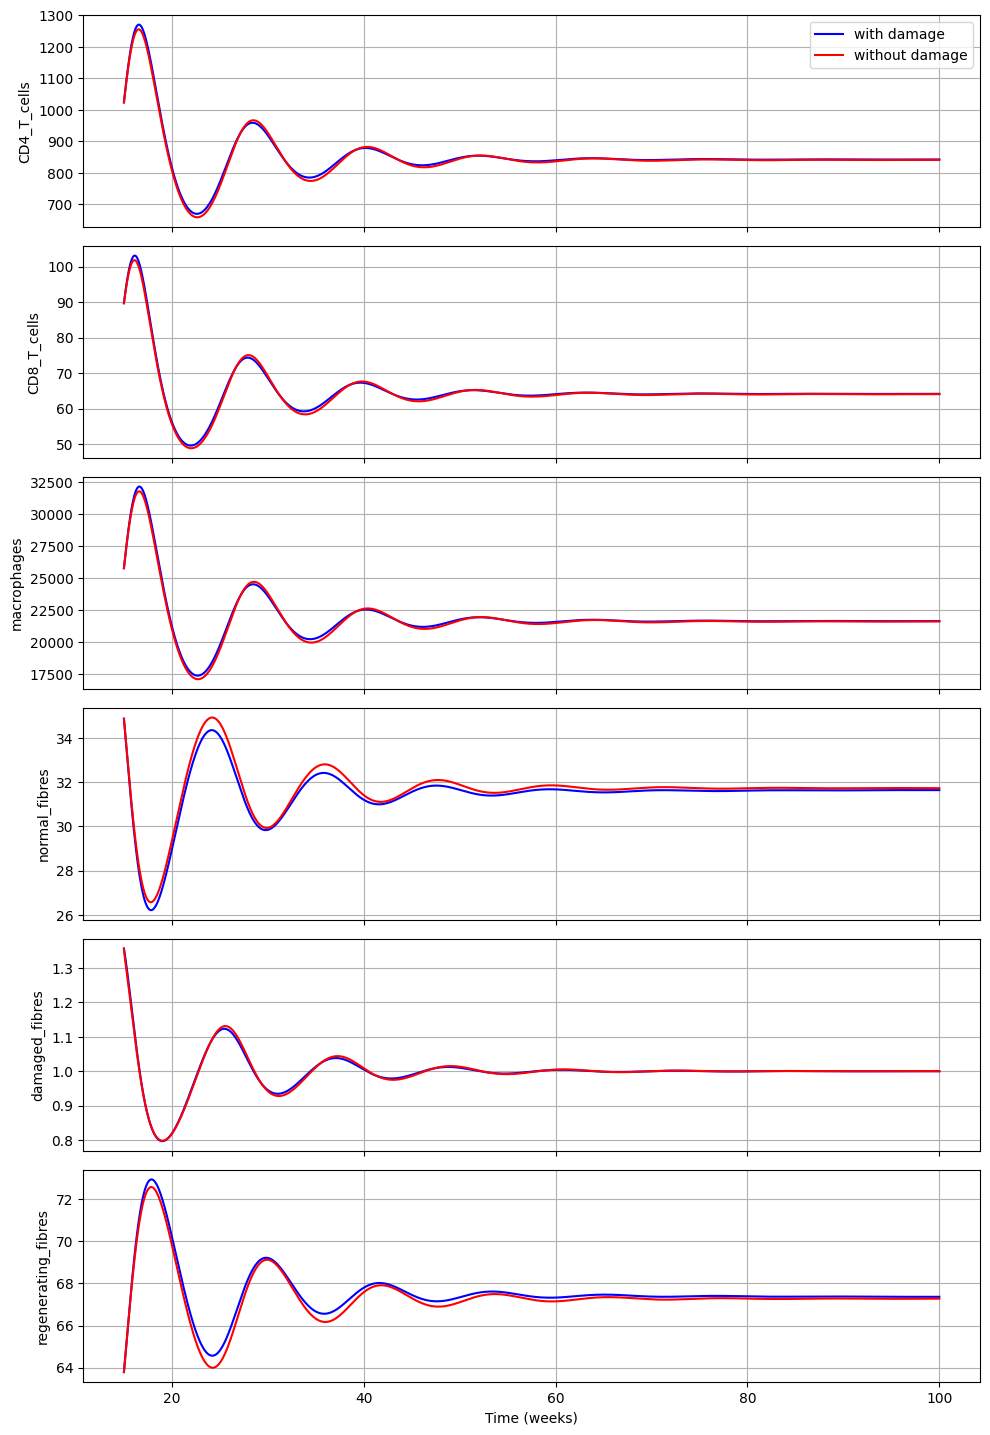

In [39]:
#Extract the needed parameters from the configuration file
config = configparser.ConfigParser()
config.read('config_damage.ini')

i_c = extract_values('initial_conditions', config)
par = extract_values('parameters', config)
sim = extract_values('simulation_par', config)
diffusion = extract_values('diff_coeff', config)
dt, t_min, t_max, t_max_2, dx, N_cells = sim
N_cells = int(N_cells)

#To study the homogeneous scenario, the boundary conditions should be set to 'periodic' or 'evolving_sym'
if 'boundary_conditions' in config:
    for key, value in config['boundary_conditions'].items():
        boundary=value
else:
    print('Section "boundary_conditions" is not in the configuration file')

#Lists of N_cells values for each state variable
H, C, M, N, D, R = [[i_c[i]] * N_cells for i in range(6)]
#Lists of N_cells values to store the uniform initial conditions
H_i, C_i, M_i, N_i, D_i, R_i = [[i_c[i]] * N_cells for i in range(6)]
#Lists of N_cells values for each state variable to store the evolution at each time step
H_new, C_new, M_new, N_new, D_new, R_new = [[i_c[i]] * N_cells for i in range(6)]

#Lists to store the configurations during the evolution
H_values = []
C_values = []
M_values = []
N_values = []
D_values = []
R_values = []

H_values_a = []
C_values_a = []
M_values_a = []
N_values_a = []
D_values_a = []
R_values_a = []

#Lists to store the values taken at each time step by the terms in the evolution expression of N   
Normal = []
dt_k4_R = []
dt_k5_C_N = []
dt_N_damage = []
terms_N = [Normal, dt_k4_R, dt_k5_C_N, dt_N_damage]
#and in that of D (for the second cell)
Damaged = []
dt_k6_D_M = []
dt_dD_D = []
terms_D = [Damaged, dt_k6_D_M, dt_dD_D]

#Array to store the time steps of the evolution from t_min to t_max_2
t = [t_min]

#Maximum step index for the first and second simulations
first_stop = int((t_max-t_min)/dt)
second_stop = int(t_max_2/dt)

#Evolution from t_min to t_max
for j in range(0, first_stop):

    one_step(t[j], dt, dx,
             H, C, M, N, D, R,
             H_new, C_new, M_new, N_new, D_new, R_new,
             H_i, C_i, M_i, par, diffusion, boundary,
             terms_N, terms_D)
    H, C, M, N, D, R = H_new.copy(), C_new.copy(), M_new.copy(), N_new.copy(), D_new.copy(), R_new.copy()

    t.append((j + 1.) / (1./dt))

'''If t_max is large enough, from this point onwards the damage function should be negligible
and the evolution computed using the autonomous and non-autonomous systems should yield the same results'''

#Create the variables necessary for simulating the evolution of the autonomous system
H_a, C_a, M_a, N_a, D_a, R_a = \
H_new.copy(), C_new.copy(), M_new.copy(), N_new.copy(), D_new.copy(), R_new.copy()

H_new_a, C_new_a, M_new_a, N_new_a, D_new_a, R_new_a = \
H_new.copy(), C_new.copy(), M_new.copy(), N_new.copy(), D_new.copy(), R_new.copy()

#Evolution from t_max to t_max_2
for j in range(first_stop, second_stop):

    one_step(t[j], dt, dx, H, C, M, N, D, R,
             H_new, C_new, M_new, N_new, D_new, R_new,
             H_i, C_i, M_i, par, diffusion, boundary,
             terms_N, terms_D)
    H, C, M, N, D, R = H_new.copy(), C_new.copy(), M_new.copy(), N_new.copy(), D_new.copy(), R_new.copy()

    one_step_autonomous(dt, dx, H_a, C_a, M_a, N_a, D_a, R_a,
                        H_new_a, C_new_a, M_new_a, N_new_a, D_new_a, R_new_a,
                        H_i, C_i, M_i, par, diffusion, boundary)
    H_a, C_a, M_a, N_a, D_a, R_a = H_new_a.copy(), C_new_a.copy(), M_new_a.copy(), N_new_a.copy(), D_new_a.copy(), R_new_a.copy()

    t.append((j + 1.) / (1./dt))
    
    H_values.append([float(value) for value in H_new])
    C_values.append([float(value) for value in C_new])
    M_values.append([float(value) for value in M_new])
    N_values.append([float(value) for value in N_new])
    D_values.append([float(value) for value in D_new])
    R_values.append([float(value) for value in R_new])

    H_values_a.append([float(value) for value in H_new_a])
    C_values_a.append([float(value) for value in C_new_a])
    M_values_a.append([float(value) for value in M_new_a])
    N_values_a.append([float(value) for value in N_new_a])
    D_values_a.append([float(value) for value in D_new_a])
    R_values_a.append([float(value) for value in R_new_a])

#Evolution for the non autonomous system in the second cell
column_H_1 = [row[1] for row in H_values]
column_C_1 = [row[1] for row in C_values]
column_M_1 = [row[1] for row in M_values]
column_N_1 = [row[1] for row in N_values]
column_D_1 = [row[1] for row in D_values]
column_R_1 = [row[1] for row in R_values]

#Evolution for the autonomous system in the second cell
column_H_1_a = [row[1] for row in H_values_a]
column_C_1_a = [row[1] for row in C_values_a]
column_M_1_a = [row[1] for row in M_values_a]
column_N_1_a = [row[1] for row in N_values_a]
column_D_1_a = [row[1] for row in D_values_a]
column_R_1_a = [row[1] for row in R_values_a]

cell_1 = [column_H_1, column_C_1, column_M_1, column_N_1, column_D_1, column_R_1]
cell_1_a = [column_H_1_a, column_C_1_a, column_M_1_a, column_N_1_a, column_D_1_a, column_R_1_a]

n_vars = len(cell_1)
labels = ['CD4_T_cells', 'CD8_T_cells', 'macrophages', 'normal_fibres', 'damaged_fibres', 'regenerating_fibres']

fig, axes = plt.subplots(n_vars, 1, figsize=(10, 15), sharex=True)

for i in range(n_vars):
    axes[i].plot(t[first_stop+1:], cell_1[i], label='with damage', color='blue')
    axes[i].plot(t[first_stop+1:], cell_1_a[i], label='without damage', color='red')
    axes[i].set_ylabel(labels[i])
    axes[i].grid(True)

axes[-1].set_xlabel('Time (weeks)')
axes[0].legend()

plt.tight_layout()
plt.subplots_adjust(top=0.95)

#plt.savefig(f'from_{t_max}_to_{t_max_2}_with_and_without_damage.png')

plt.show()

This cell plots the time evolution of the terms that appear in the evolution equation for normal fibres.

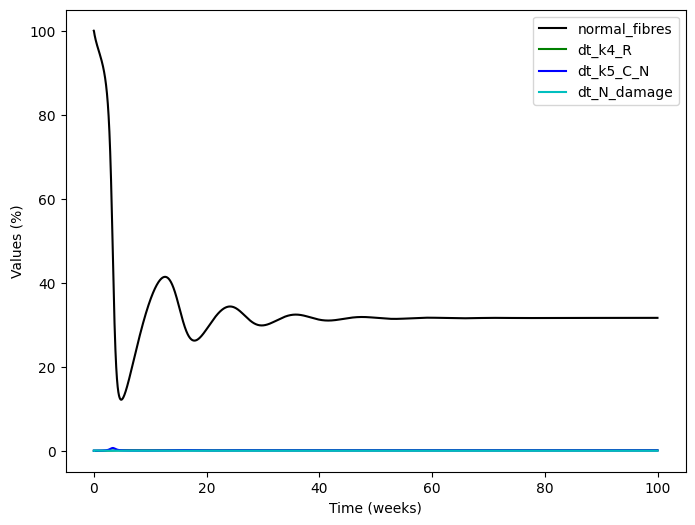

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))

if len(terms_N[0]) != len(t):
    t.pop()

ax.plot(t, terms_N[0], label='normal_fibres', color='k', linestyle='-')
ax.plot(t, terms_N[1], label='dt_k4_R', color='g')
ax.plot(t, terms_N[2], label='dt_k5_C_N', color='b')
ax.plot(t, terms_N[3], label='dt_N_damage', color='c')

ax.set_xlabel('Time (weeks)')
ax.set_ylabel('Values (%)')
ax.legend(loc='upper right')

#plt.savefig('all_terms_in_N')

plt.show()

This cell plots the time evolution of the terms that appear in the evolution equation for damaged fibres.

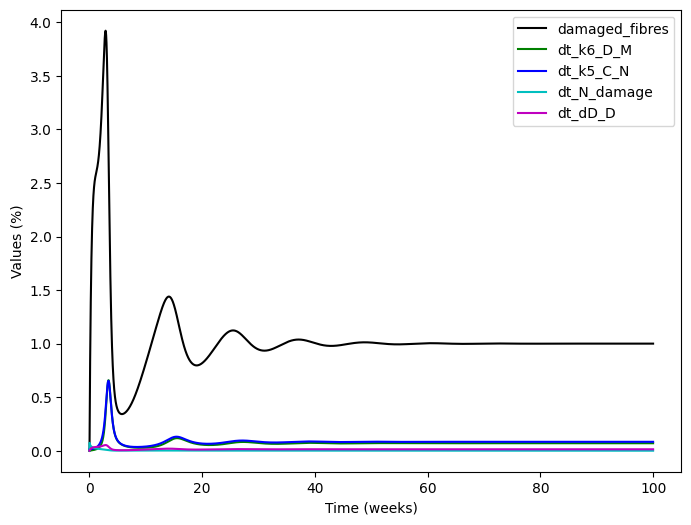

In [41]:
fig, ax = plt.subplots(figsize=(8, 6))

if len(terms_N[0]) != len(t):
    t.pop()

# Plot each dataset on the same plot with a label for the legend
ax.plot(t, terms_D[0], label='damaged_fibres', color='k')
ax.plot(t, terms_D[1], label='dt_k6_D_M', color='g')
ax.plot(t, terms_N[2], label='dt_k5_C_N', color='b')
ax.plot(t, terms_N[3], label='dt_N_damage', color='c')
ax.plot(t, terms_D[2], label='dt_dD_D', color='m')

ax.set_xlabel('Time (weeks)')
ax.set_ylabel('Values (%)')
ax.legend(loc='upper right')

#plt.savefig('all_terms_in_D')

plt.show()

## Forced mass conservation
### Alternative implementation for the evolution of the system
The second part of this notebook does not require storing the values of each term in the evolution of N and D; therefore simpler implementations of ev_N and ev_D are provided. Additionally, a modified version of the evolution function is included, where the explicit expression for the evolution of R is replaced with the condition of mass conservation.

In [42]:
#Non autonomous
def one_step(t, dt, dx, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, H_i, C_i, M_i, par, diffusion, boundary):

    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = par
    D_H, D_C, D_M = diffusion

    for i in range(len(H)):

        ev_H(i, dt, dx, D_H, d_H, k1, H_i, H, M, D, H_new, boundary)
        ev_C(i, dt, dx, D_C, d_C, k2, C_i, C, H, D, C_new, boundary)
        ev_M(i, dt, dx, D_M, d_M, k3, M_i, M, D, M_new, boundary)
        ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new)
        ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new)
        ev_R(i, dt, d_D, k4, k6, M, D, R, R_new)
        
#Non autonomous modified forcing the conservation of mass
def one_step_modified(t, dt, dx, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, H_i, C_i, M_i, par, diffusion, boundary):

    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = par
    D_H, D_C, D_M = diffusion

    for i in range(len(H)):

        ev_H(i, dt, dx, D_H, d_H, k1, H_i, H, M, D, H_new, boundary)
        ev_C(i, dt, dx, D_C, d_C, k2, C_i, C, H, D, C_new, boundary)
        ev_M(i, dt, dx, D_M, d_M, k3, M_i, M, D, M_new, boundary)
        ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new)
        ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new)
        ev_R_mod(i, N_new, D_new, R_new)

#Autonomous
def one_step_autonomous_modified(dt, dx, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, H_i, C_i, M_i, par, diffusion, boundary):

    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = par
    D_H, D_C, D_M = diffusion

    for i in range(len(H)):

        ev_H(i, dt, dx, D_H, d_H, k1, H_i, H, M, D, H_new, boundary)
        ev_C(i, dt, dx, D_C, d_C, k2, C_i, C, H, D, C_new, boundary)
        ev_M(i, dt, dx, D_M, d_M, k3, M_i, M, D, M_new, boundary)
        ev_N_autonomous(i, dt, k4, k5, R, C, N, N_new)
        ev_D_autonomous(i, dt, d_D, k5, k6, C, M, N, D, D_new)
        ev_R_mod(i, N_new, D_new, R_new)

def ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new):
    N_new[i] = N[i] + dt * (k4 * R[i] - N[i] * (k5 * C[i] + damage(t, sigma, m, h)))
        
def ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new):
    D_new[i] = D[i] + dt * (N[i] * (k5 * C[i] + damage(t, sigma, m, h)) - D[i] * (k6 * M[i] + d_D))

def ev_R_mod(i, N_new, D_new, R_new):
    R_new[i] = 100 - N_new[i] - D_new[i]

### Simulation
This code computes the evolution of both the autonomous and the non-autonomous systems from t_min=0 to t_max. Both the original and modified versions of the system are implemented, resulting in four different evolutions being computed simultaneously. Their outputs can be plotted together to verify whether the expected overlap of the evolutions occurs. Variables referring to the modified versions are marked with '_m'.

In [43]:
#Evolution over this range of time:
t_min = 0.
t_max = 100.

H, C, M, N, D, R = [[i_c[i]] * N_cells for i in range(6)]
H_m, C_m, M_m, N_m, D_m, R_m = [[i_c[i]] * N_cells for i in range(6)]
H_a, C_a, M_a, N_a, D_a, R_a = [[i_c[i]] * N_cells for i in range(6)]
H_a_m, C_a_m, M_a_m, N_a_m, D_a_m, R_a_m = [[i_c[i]] * N_cells for i in range(6)]
H_i, C_i, M_i, N_i, D_i, R_i = [[i_c[i]] * N_cells for i in range(6)]
H_new, C_new, M_new, N_new, D_new, R_new = [[i_c[i]] * N_cells for i in range(6)]
H_new_m, C_new_m, M_new_m, N_new_m, D_new_m, R_new_m = [[i_c[i]] * N_cells for i in range(6)]
H_new_a, C_new_a, M_new_a, N_new_a, D_new_a, R_new_a = [[i_c[i]] * N_cells for i in range(6)]
H_new_a_m, C_new_a_m, M_new_a_m, N_new_a_m, D_new_a_m, R_new_a_m = [[i_c[i]] * N_cells for i in range(6)]

#lists of N_cells values for each state variable, used to store the evolution at each time step.
H_values = [[i_c[0]] * N_cells]
C_values = [[i_c[1]] * N_cells]
M_values = [[i_c[2]] * N_cells]
N_values = [[i_c[3]] * N_cells]
D_values = [[i_c[4]] * N_cells]
R_values = [[i_c[5]] * N_cells]

H_values_m = [[i_c[0]] * N_cells]
C_values_m = [[i_c[1]] * N_cells]
M_values_m = [[i_c[2]] * N_cells]
N_values_m = [[i_c[3]] * N_cells]
D_values_m = [[i_c[4]] * N_cells]
R_values_m = [[i_c[5]] * N_cells]

H_values_a = [[i_c[0]] * N_cells]
C_values_a = [[i_c[1]] * N_cells]
M_values_a = [[i_c[2]] * N_cells]
N_values_a = [[i_c[3]] * N_cells]
D_values_a = [[i_c[4]] * N_cells]
R_values_a = [[i_c[5]] * N_cells]

H_values_a_m = [[i_c[0]] * N_cells]
C_values_a_m = [[i_c[1]] * N_cells]
M_values_a_m = [[i_c[2]] * N_cells]
N_values_a_m = [[i_c[3]] * N_cells]
D_values_a_m = [[i_c[4]] * N_cells]
R_values_a_m = [[i_c[5]] * N_cells]

#Array to store the time steps
t = [t_min]

for j in range(int((t_max - t_min) / dt)):

#Evolution of the original non-autonomous system
    one_step(t[j], dt, dx, H, C, M, N, D, R,
             H_new, C_new, M_new, N_new, D_new, R_new,
             H_i, C_i, M_i, par, diffusion, boundary)
    
    H, C, M, N, D, R = H_new.copy(), C_new.copy(), M_new.copy(), N_new.copy(), D_new.copy(), R_new.copy()

#Evolution of the modified non-autonomous system
    one_step_modified(t[j], dt, dx, H_m, C_m, M_m, N_m, D_m, R_m,
             H_new_m, C_new_m, M_new_m, N_new_m, D_new_m, R_new_m,
             H_i, C_i, M_i, par, diffusion, boundary)
    
    H_m, C_m, M_m, N_m, D_m, R_m = H_new_m.copy(), C_new_m.copy(), M_new_m.copy(), N_new_m.copy(), D_new_m.copy(), R_new_m.copy()

#Evolution of the original autonomous system
    one_step_autonomous(dt, dx, H_a, C_a, M_a, N_a, D_a, R_a,
                        H_new_a, C_new_a, M_new_a, N_new_a, D_new_a, R_new_a,
                        H_i, C_i, M_i, par, diffusion, boundary)
    
    H_a, C_a, M_a, N_a, D_a, R_a = H_new_a.copy(), C_new_a.copy(), M_new_a.copy(), N_new_a.copy(), D_new_a.copy(), R_new_a.copy()

#Evolution of the modified autonomous system
    one_step_autonomous_modified(dt, dx, H_a_m, C_a_m, M_a_m, N_a_m, D_a_m, R_a_m,
                        H_new_a_m, C_new_a_m, M_new_a_m, N_new_a_m, D_new_a_m, R_new_a_m,
                        H_i, C_i, M_i, par, diffusion, boundary)
    
    H_a_m, C_a_m, M_a_m, N_a_m, D_a_m, R_a_m = \
    H_new_a_m.copy(), C_new_a_m.copy(), M_new_a_m.copy(), N_new_a_m.copy(), D_new_a_m.copy(), R_new_a_m.copy()    

    t.append(round(t[-1] + dt, 2)) #be careful if you change dt

    H_values.append([float(value) for value in H_new])
    C_values.append([float(value) for value in C_new])
    M_values.append([float(value) for value in M_new])
    N_values.append([float(value) for value in N_new])
    D_values.append([float(value) for value in D_new])
    R_values.append([float(value) for value in R_new])

    H_values_m.append([float(value) for value in H_new_m])
    C_values_m.append([float(value) for value in C_new_m])
    M_values_m.append([float(value) for value in M_new_m])
    N_values_m.append([float(value) for value in N_new_m])
    D_values_m.append([float(value) for value in D_new_m])
    R_values_m.append([float(value) for value in R_new_m])
    
    H_values_a.append([float(value) for value in H_new_a])
    C_values_a.append([float(value) for value in C_new_a])
    M_values_a.append([float(value) for value in M_new_a])
    N_values_a.append([float(value) for value in N_new_a])
    D_values_a.append([float(value) for value in D_new_a])
    R_values_a.append([float(value) for value in R_new_a])

    H_values_a_m.append([float(value) for value in H_new_a_m])
    C_values_a_m.append([float(value) for value in C_new_a_m])
    M_values_a_m.append([float(value) for value in M_new_a_m])
    N_values_a_m.append([float(value) for value in N_new_a_m])
    D_values_a_m.append([float(value) for value in D_new_a_m])
    R_values_a_m.append([float(value) for value in R_new_a_m])

#Evolution for the non autonomous system in the second cell (representative of the whole system when boundary='periodic')
column_H_1 = [row[1] for row in H_values]
column_C_1 = [row[1] for row in C_values]
column_M_1 = [row[1] for row in M_values]
column_N_1 = [row[1] for row in N_values]
column_D_1 = [row[1] for row in D_values]
column_R_1 = [row[1] for row in R_values]

column_H_1_m = [row[1] for row in H_values_m]
column_C_1_m = [row[1] for row in C_values_m]
column_M_1_m = [row[1] for row in M_values_m]
column_N_1_m = [row[1] for row in N_values_m]
column_D_1_m = [row[1] for row in D_values_m]
column_R_1_m = [row[1] for row in R_values_m]

#Evolution for the autonomous system in the second cell
column_H_1_a = [row[1] for row in H_values_a]
column_C_1_a = [row[1] for row in C_values_a]
column_M_1_a = [row[1] for row in M_values_a]
column_N_1_a = [row[1] for row in N_values_a]
column_D_1_a = [row[1] for row in D_values_a]
column_R_1_a = [row[1] for row in R_values_a]

column_H_1_a_m = [row[1] for row in H_values_a_m]
column_C_1_a_m = [row[1] for row in C_values_a_m]
column_M_1_a_m = [row[1] for row in M_values_a_m]
column_N_1_a_m = [row[1] for row in N_values_a_m]
column_D_1_a_m = [row[1] for row in D_values_a_m]
column_R_1_a_m = [row[1] for row in R_values_a_m]

cell_1 = [column_H_1, column_C_1, column_M_1, column_N_1, column_D_1, column_R_1]
cell_1_m = [column_H_1_m, column_C_1_m, column_M_1_m, column_N_1_m, column_D_1_m, column_R_1_m]
cell_1_a = [column_H_1_a, column_C_1_a, column_M_1_a, column_N_1_a, column_D_1_a, column_R_1_a]
cell_1_a_m = [column_H_1_a_m, column_C_1_a_m, column_M_1_a_m, column_N_1_a_m, column_D_1_a_m, column_R_1_a_m]

n_vars = len(cell_1)
labels = ['CD4_T_cells', 'CD8_T_cells', 'macrophages', 'normal_fibres', 'damaged_fibres', 'regenerating_fibres']


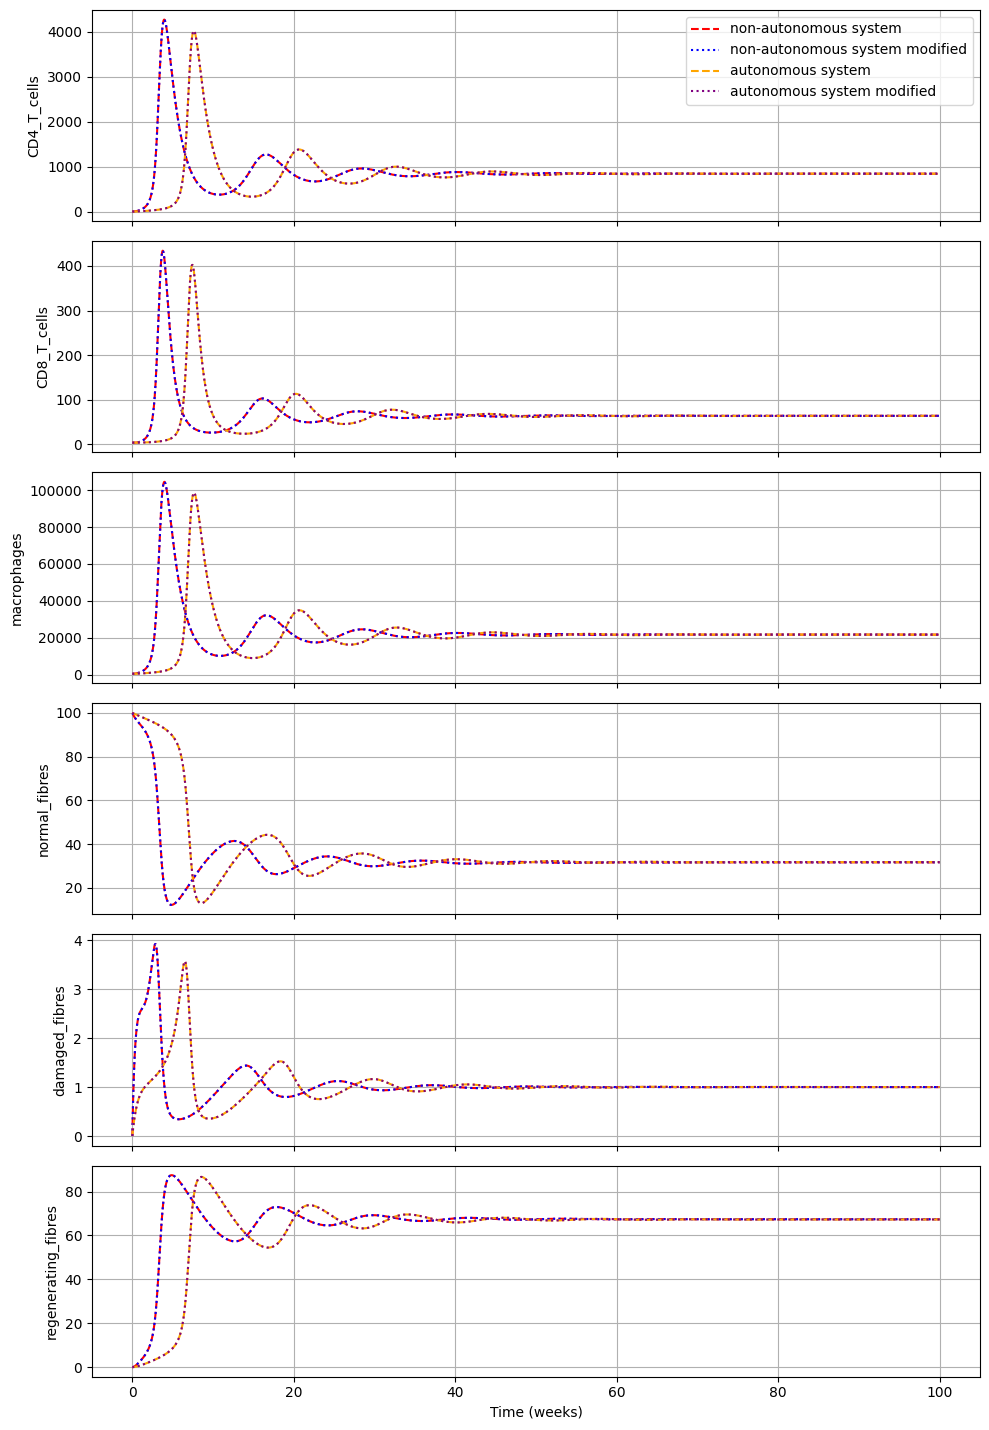

In [46]:
fig, axes = plt.subplots(n_vars, 1, figsize=(10, 15), sharex=True)

for i in range(n_vars):
    axes[i].plot(t, cell_1[i], label='non-autonomous system', color='red', linestyle='--')
    axes[i].plot(t, cell_1_m[i], label='non-autonomous system modified', color='blue', linestyle=':')
    axes[i].plot(t, cell_1_a[i], label='autonomous system', color='orange', linestyle='--')
    axes[i].plot(t, cell_1_a_m[i], label='autonomous system modified', color='purple', linestyle=':')
    axes[i].set_ylabel(labels[i])
    axes[i].grid(True)

axes[-1].set_xlabel('Time (weeks)')
axes[0].legend()

plt.tight_layout()
plt.subplots_adjust(top=0.95)

#plt.savefig('autonomous_vs_non_vs_mass_conservation.png')

plt.show()